In [309]:
import torch
from torch import nn
import math

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

### A) Using Net and Train

In [310]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten for FC
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [311]:
def train(model, trainloader, optimizer):
    loss_func = nn.CrossEntropyLoss()
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    # For every batch
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / len(trainloader)
    epoch_acc = (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [312]:
def test(model, testloader):
    loss_func = nn.CrossEntropyLoss()
    model.eval()

    test_running_loss = 0.0
    test_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            outputs = model(image)
            loss = loss_func(outputs, labels)
            test_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels).sum().item()

    epoch_loss = test_running_loss / len(testloader)
    epoch_acc = (test_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [313]:
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
download_data = True
# device = torch.device('cpu')
epochs = 5
batch_size = 64

transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor()])
                                             

In [314]:
def epoch_train(train_dataloader_, test_dataloader_):
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay=0.0005)
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_dataloader_, optimizer)
        test_epoch_loss, test_epoch_acc = test(model, test_dataloader_)
        train_loss.append(train_epoch_loss)
        test_loss.append(test_epoch_loss)
        train_acc.append(train_epoch_acc)
        test_acc.append(test_epoch_acc)
        print('\n')
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Test loss: {test_epoch_loss:.3f}, test acc: {test_epoch_acc:.3f}")
        print('-'*50)
    return model, train_loss, test_loss, train_acc, test_acc

In [315]:
# dataset and data loader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=download_data, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
model, train_loss, test_loss, train_acc, test_acc = epoch_train(train_dataloader, test_dataloader)

[INFO]: Epoch 1 of 5


100%|██████████| 157/157 [00:01<00:00, 132.12it/s]




Training loss: 0.132, training acc: 0.959
Test loss: 0.053, test acc: 0.983
--------------------------------------------------
[INFO]: Epoch 2 of 5


100%|██████████| 157/157 [00:01<00:00, 131.40it/s]




Training loss: 0.037, training acc: 0.990
Test loss: 0.033, test acc: 0.991
--------------------------------------------------
[INFO]: Epoch 3 of 5


100%|██████████| 157/157 [00:01<00:00, 132.80it/s]




Training loss: 0.028, training acc: 0.992
Test loss: 0.024, test acc: 0.993
--------------------------------------------------
[INFO]: Epoch 4 of 5


100%|██████████| 157/157 [00:01<00:00, 133.02it/s]




Training loss: 0.022, training acc: 0.994
Test loss: 0.027, test acc: 0.993
--------------------------------------------------
[INFO]: Epoch 5 of 5


100%|██████████| 157/157 [00:01<00:00, 131.24it/s]



Training loss: 0.017, training acc: 0.995
Test loss: 0.020, test acc: 0.995
--------------------------------------------------


### B) Using FGSM to generate adversarial examples and test

In [316]:
def fgsm_attack(model, image, label, loss_func, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = loss_func(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def adversarial_test(model, test_dataloader_, epsilon, attacker):
    loss_func = nn.CrossEntropyLoss()
    model.eval()
    adv_acc = 0
    adv_examples = []
    for idx, data in tqdm(enumerate(test_dataloader_), total=len(test_dataloader_)):
        image, label = data
        image = image.to(device)
        label = label.to(device)

        # perturb the image with the calculated gradient
        perturbed_image = attacker(model, image, label, loss_func, epsilon)

        # calculate the model output on the perturbed image
        output = model(perturbed_image)
        _, final_pred = torch.max(output.data, 1)
        adv_acc += (final_pred == label).sum().item()
        # if final_pred.item() == label.item():
            # adv_acc += 1
        # else:
        for i in range(batch_size):
            if len(adv_examples) >= 5:
                break
            if final_pred[i].item() != label[i].item():
                adv_ex = perturbed_image[i].squeeze().detach().cpu().numpy()
                adv_examples.append( (final_pred[i].item(), label[i].item(), adv_ex) )

    adv_acc = adv_acc / len(test_dataloader_.dataset)
    return adv_acc, adv_examples

In [317]:
def test_with_eps(model, test_dataloader_, epsilons, attacker):
    accuracies = []
    examples = []

    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = adversarial_test(model, test_dataloader, eps, fgsm_attack)
        accuracies.append(acc)
        examples.append(ex)
    print(accuracies)
    return accuracies, examples

In [318]:
epsilons = [0.1, 0.2, 0.5]
origin_acc, fgsm_examples = test_with_eps(model, test_dataloader, epsilons, fgsm_attack)

100%|██████████| 157/157 [00:02<00:00, 68.13it/s]

[0.8326, 0.2692, 0.1006]


In [319]:
print(accuracies)

[0.7456, 0.1217, 0.0972]


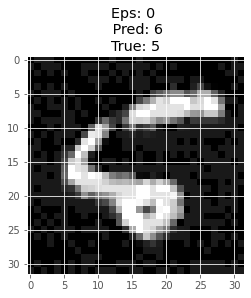

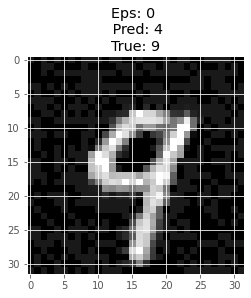

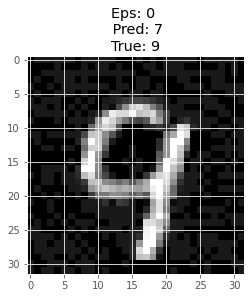

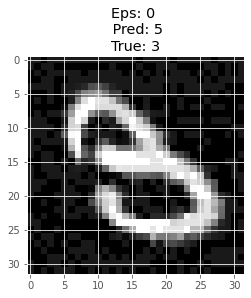

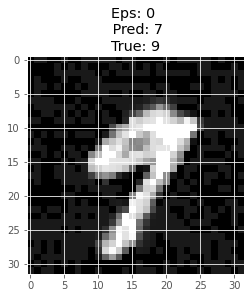

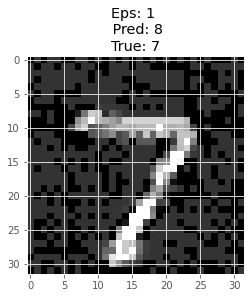

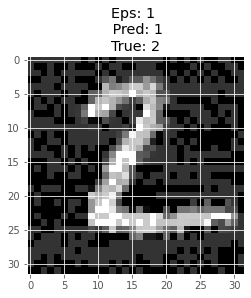

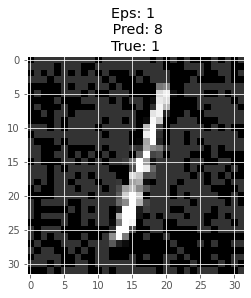

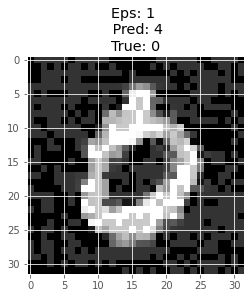

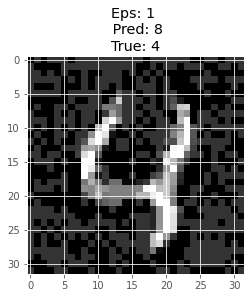

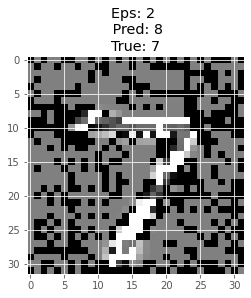

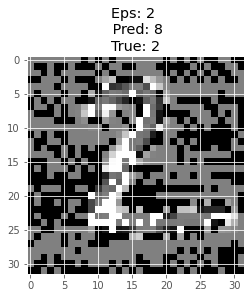

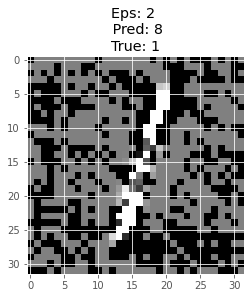

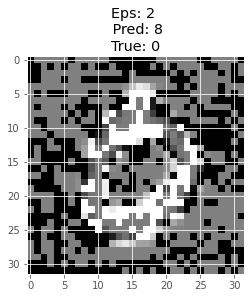

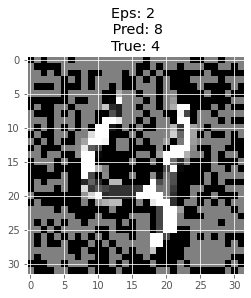

In [320]:
for i, eps in enumerate(epsilons):
    for ex in fgsm_examples[i]:
        # print(ex)
        plt.imshow(ex[2], cmap='gray')
        plt.title("Eps: {} \n Pred: {}\nTrue: {}".format(i, ex[0], ex[1]))
        plt.show()
        plt.close()

### C) Adversarial training

In [321]:
TRAINING_EPS = 0.2

In [322]:
def adversarial_train(model, trainloader, optimizer, epsilon, attacker):
    loss_func = nn.CrossEntropyLoss()
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    # For every batch
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        perturbed_image = attacker(model, image, labels, loss_func, epsilon)

        # Train the model output on the perturbed image
        optimizer.zero_grad()
        outputs = model(perturbed_image)
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / len(trainloader)
    epoch_acc = (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def adversarial_epoch_train(train_dataloader_, train_eps, attacker):
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay=0.0005)
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = adversarial_train(model, train_dataloader_, optimizer, train_eps, attacker)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        print('\n')
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print('-'*50)
    return model, train_loss, train_acc

In [323]:
# dataset and data loader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=download_data, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
adv_model, train_loss, train_acc = adversarial_epoch_train(train_dataloader, TRAINING_EPS, fgsm_attack)

[INFO]: Epoch 1 of 5


100%|██████████| 938/938 [00:17<00:00, 53.35it/s]




Training loss: 0.403, training acc: 0.865
--------------------------------------------------
[INFO]: Epoch 2 of 5


100%|██████████| 938/938 [00:17<00:00, 53.68it/s]




Training loss: 0.054, training acc: 0.984
--------------------------------------------------
[INFO]: Epoch 3 of 5


100%|██████████| 938/938 [00:18<00:00, 49.67it/s]




Training loss: 0.028, training acc: 0.992
--------------------------------------------------
[INFO]: Epoch 4 of 5


100%|██████████| 938/938 [00:18<00:00, 51.23it/s]




Training loss: 0.020, training acc: 0.994
--------------------------------------------------
[INFO]: Epoch 5 of 5


100%|██████████| 938/938 [00:17<00:00, 53.41it/s]



Training loss: 0.018, training acc: 0.995
--------------------------------------------------


In [324]:
epsilons = [0.1, 0.2, 0.5]
fgsm_training_acc, fgsm_training_examples = test_with_eps(adv_model, test_dataloader, epsilons, fgsm_attack)

100%|██████████| 157/157 [00:02<00:00, 66.49it/s]

[0.9946, 0.9609, 0.3009]


### D) PGD

In [351]:
ETA = 0.01
NUM_ITER = 10
def pgd_attack(model, image, label, loss_func, epsilon, step=ETA, num_iter=NUM_ITER):
    delta = torch.zeros_like(image, requires_grad=True).to(device)
    for t in range(num_iter):
        loss = loss_func(model(delta + image), label)
        loss.backward()
        delta.data = (delta + step * delta.grad.data.sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    
    perturbed_image = image + delta.data
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


In [352]:
# dataset and data loader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=download_data, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=download_data, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
pgd_model, train_loss, train_acc = adversarial_epoch_train(train_dataloader, TRAINING_EPS, pgd_attack)

[INFO]: Epoch 1 of 5


100%|██████████| 938/938 [01:19<00:00, 11.84it/s]




Training loss: 0.366, training acc: 0.880
--------------------------------------------------
[INFO]: Epoch 2 of 5


100%|██████████| 938/938 [01:16<00:00, 12.25it/s]




Training loss: 0.164, training acc: 0.949
--------------------------------------------------
[INFO]: Epoch 3 of 5


100%|██████████| 938/938 [01:16<00:00, 12.23it/s]




Training loss: 0.129, training acc: 0.959
--------------------------------------------------
[INFO]: Epoch 4 of 5


100%|██████████| 938/938 [01:15<00:00, 12.41it/s]




Training loss: 0.112, training acc: 0.965
--------------------------------------------------
[INFO]: Epoch 5 of 5


100%|██████████| 938/938 [01:17<00:00, 12.06it/s]



Training loss: 0.097, training acc: 0.969
--------------------------------------------------


In [353]:
epsilons = [0.1, 0.2, 0.5]
pgd_training_acc, pgd_training_examples = test_with_eps(pgd_model, test_dataloader, epsilons, fgsm_attack)

100%|██████████| 157/157 [00:02<00:00, 65.35it/s]

[0.9637, 0.8515, 0.1055]


In [354]:
models = [model, adv_model, pgd_model]

origin_accs = [ test(m, test_dataloader)[1] for m in models ]
fgsm_accs = np.array([ test_with_eps(m, test_dataloader, epsilons, fgsm_attack)[0] for m in models ])
pgd_accs = np.array([ test_with_eps(m, test_dataloader, epsilons, pgd_attack)[0] for m in models ])

100%|██████████| 157/157 [00:02<00:00, 65.32it/s]


[0.8326, 0.2692, 0.1006]


100%|██████████| 157/157 [00:02<00:00, 66.09it/s]


[0.9946, 0.9609, 0.3009]


100%|██████████| 157/157 [00:02<00:00, 66.54it/s]


[0.9637, 0.8515, 0.1055]


100%|██████████| 157/157 [00:02<00:00, 66.09it/s]


[0.8326, 0.2692, 0.1006]


100%|██████████| 157/157 [00:02<00:00, 65.29it/s]


[0.9946, 0.9609, 0.3009]


100%|██████████| 157/157 [00:02<00:00, 65.43it/s]

[0.9637, 0.8515, 0.1055]


In [355]:
for i, eps in enumerate(epsilons):
    print(f"Epsilon: {eps}")
    print("Attackers \t Standard Training \t FGSM Training \t PGD Training")
    print("---------------------------------------------------------------")
    print("Original  \t {}                \t {}            \t {}".format(*origin_accs))
    print("FGSM      \t {}                \t {}            \t {}".format(fgsm_accs[0,i], fgsm_accs[1,i], fgsm_accs[2,i]))
    print("PGD       \t {}                \t {}            \t {}".format(pgd_accs[0,i], pgd_accs[1,i], pgd_accs[2,i]))
    print()

Epsilon: 0.1
Attackers 	 Standard Training 	 FGSM Training 	 PGD Training
---------------------------------------------------------------
Original  	 0.9947                	 0.9871            	 0.9917
FGSM      	 0.8326                	 0.9946            	 0.9637
PGD       	 0.8326                	 0.9946            	 0.9637

Epsilon: 0.2
Attackers 	 Standard Training 	 FGSM Training 	 PGD Training
---------------------------------------------------------------
Original  	 0.9947                	 0.9871            	 0.9917
FGSM      	 0.2692                	 0.9609            	 0.8515
PGD       	 0.2692                	 0.9609            	 0.8515

Epsilon: 0.5
Attackers 	 Standard Training 	 FGSM Training 	 PGD Training
---------------------------------------------------------------
Original  	 0.9947                	 0.9871            	 0.9917
FGSM      	 0.1006                	 0.3009            	 0.1055
PGD       	 0.1006                	 0.3009            	 0.1055

